In [2]:
%matplotlib inline
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

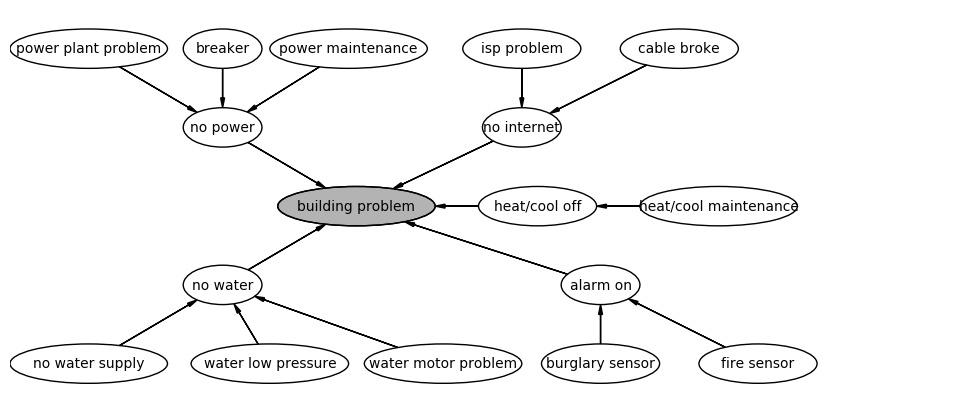

In [69]:
pgm = daft.PGM([12, 5], origin=[1, 0.5])
"""
    17 nodes
"""
pgm.add_node(daft.Node('pm', 'power maintenance', 5.3, 5, aspect=4))
pgm.add_node(daft.Node('br', 'breaker', 3.7, 5, aspect=2))
pgm.add_node(daft.Node('ppp', 'power plant problem', 2, 5, aspect=4))

pgm.add_node(daft.Node('np', 'no power', 3.7, 4, aspect=2))


pgm.add_node(daft.Node('isp', 'isp problem', 7.5, 5, aspect=3))
pgm.add_node(daft.Node('csb', 'cable broke', 9.5, 5, aspect=3))

pgm.add_node(daft.Node('ni', 'no internet', 7.5, 4, aspect=2))


pgm.add_node(daft.Node('hcm', 'heat/cool maintenance', 10, 3, aspect=4))

pgm.add_node(daft.Node('hc', 'heat/cool off', 7.7, 3, aspect=3))


pgm.add_node(daft.Node('bp', 'building problem', 5.4, 3, aspect=4, observed=True))


pgm.add_node(daft.Node('nw', 'no water', 3.7, 2, aspect=2))

pgm.add_node(daft.Node('wm', 'water motor problem', 6.5, 1, aspect=4))
pgm.add_node(daft.Node('wp', 'water low pressure', 4.3, 1, aspect=4))
pgm.add_node(daft.Node('ws', 'no water supply', 2, 1, aspect=4))


pgm.add_node(daft.Node('al', 'alarm on', 8.5, 2, aspect=2))

pgm.add_node(daft.Node('bs', 'burglary sensor', 8.5, 1, aspect=3))
pgm.add_node(daft.Node('fs', 'fire sensor', 10.5, 1, aspect=3))


pgm.add_edge('pm', 'np')
pgm.add_edge('br', 'np')
pgm.add_edge('ppp', 'np')

pgm.add_edge('isp', 'ni')
pgm.add_edge('csb', 'ni')

pgm.add_edge('hcm', 'hc')

pgm.add_edge('wm', 'nw')
pgm.add_edge('wp', 'nw')
pgm.add_edge('ws', 'nw')

pgm.add_edge('bs', 'al')
pgm.add_edge('fs', 'al')


pgm.add_edge('np', 'bp')
pgm.add_edge('ni', 'bp')
pgm.add_edge('hc', 'bp')
pgm.add_edge('nw', 'bp')
pgm.add_edge('al', 'bp')

pgm.render()

In [8]:
# Initialization
observed_values = [1.]

power_plant = pymc.Bernoulli('power_plant', .001, value=np.ones(len(observed_values)))
power_maintenance = pymc.Bernoulli('power_maintenance', .027, value=np.ones(len(observed_values)))
power_breaker = pymc.Bernoulli('power_breaker', .01, value=np.ones(len(observed_values)))

p_nopower = pymc.Lambda('p_nopower', lambda power_breaker=power_breaker, power_maintenance=power_maintenance, power_plant=power_plant: np.where(power_breaker, 
                                                                                                                                                    np.where(power_maintenance,
                                                                                                                                                    np.where(power_plant, 1, .9),
                                                                                                                                                    np.where(power_plant, .95, .85)),
                                                                                                                                                    np.where(power_maintenance,
                                                                                                                                                    np.where(power_plant, 0.7, .2),
                                                                                                                                                    np.where(power_plant, 0.6, .2))))
nopower = pymc.Bernoulli('nopower', p_nopower, value=observed_values, observed=True)

# p_nopower = pymc.Lambda('p_nopower', lambda power_breaker=power_breaker, power_maintenance=power_maintenance, power_plant=power_plant: np.where(
#                                                                                                                                                 power_breaker, 
#                                                                                                                                                     power_maintenance,
#                                                                                                                                                     np.where(power_plant, 1, .9),
#                                                                                                                                                     np.where(power_plant, .95, .85),
#                                                                                                                                                     np.where(power_plant, .7, .2), 
#                                                                                                                                                     np.where(power_plant, .6, 0)))

# isp_problem = pymc.Bernoulli('isp_problem', .1, value=np.ones(len(observed_values)))
# cable_broke = pymc.Bernoulli('cable_broke', .001, value=np.ones(len(observed_values)))

# p_nointernet = pymc.Lambda('p_nointernet', lambda isp_problem=isp_problem, cable_broke=cable_broke: np.where(isp_problem, np.where(cable_broke, .99, .9), 
#                                                                                          np.where(cable_broke, .8, 0.2)))


fire_sensor = pymc.Bernoulli('fire_sensor', .001, value=np.ones(len(observed_values)))
burglary_sensor = pymc.Bernoulli('burglary_sensor', .0001, value=np.ones(len(observed_values)))

p_alarmon = pymc.Lambda('p_alarmon', lambda burglary_sensor=burglary_sensor, fire_sensor=fire_sensor: np.where(burglary_sensor, np.where(fire_sensor, .9, .7), 
                                                                                         np.where(fire_sensor, .6, 0.1)))

alarmon = pymc.Bernoulli('alarmon', p_alarmon, value=observed_values, observed=True)
# model = pymc.Model([alarmon, p_alarmon, fire_sensor, burglary_sensor])
model = pymc.Model([nopower, p_nopower, power_plant, power_maintenance,power_breaker])

graph = pymc.graph.graph(model)
graph.write_png("graph.png")

True